# Analyze network balance with frustration index an algebraic conflict

In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import tqdm
import os
from tqdm import tqdm
import glob

import sys
sys.path.append('../local/bin/')

from sygno.signed_networkx import draw_signed_networkx

____________________

In [2]:
dataset_folder = '../dataset/'

Load the dataframe created in the *data_parsing.ipynb* containing all the information about the members of the congresses

In [3]:
pol = pd.read_csv(dataset_folder + 'members.csv')
pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'yellow'))
pol.head()

,icpsr,congress,party_code,bioname,state_abbrev,party_name,color
0,1,[82],[200],"AANDAHL, Fred George",ND,['Republican'],firebrick
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,['Democrat'],royalblue
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,['Whig'],yellow
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,['Democrat'],royalblue
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"['Crawford Republican', 'Democrat-Republican']",firebrick


Create a dictionary that links each icpsr to a party. Notice that an icpsr identifies uniquely a legislator, but a legislator can have more than one icpsr. This is because the icpsr is assigned to a legislator for each congress. For example, if a legislator is elected in 2000 and reelected in 2002, he will have two different icpsr, one for each congress. We will use the icpsr of the first congress in which the legislator was elected.

In [6]:
pol_dic = pol[['icpsr', 'party_name']].set_index('icpsr').to_dict(orient="index")
# e.g.
pol_dic[7777]

{'party_name': "['Republican']"}

In [7]:
def draw_graph(df, pol_dic):

    # Arguments:
	# df ---> edgelist
	# pol_dic ---> dictionary where key is icpsr and value is party_name
	# congress_num ---> congress number

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.icpsr)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0],  'congress': list(g.congress)[0], 'name': list(g.bioname)[0]} for k, g in pol.groupby('icpsr')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3, sort_by='party')
    
    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[int(p)]['party_name'] == 'Democrat' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[int(p)]['party_name']] += 1
        else:
            if pol_dic[int(p)]['party_name'] == 'party_name' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[int(p)]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

    return least_eigenvalue

In [8]:
def read_edgelist(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])
    

    least_eigen = draw_graph(df, pol_dic)

    return least_eigen

In [9]:
thresholds_path = '../dataset/thresholds/'
edgelists_path = '../dataset/edgelists/'

_______________________________________________________________

## Compute the Algebraic Conflict
##### i.e. the smallest eigenvalue of the (signed) Laplacian matrix

In [24]:
# create a dictionary with congress number as key, the U.S. president in that year and the two years when it took place as value.
congress_years_dic = {
    77: ['Truman', '1941-1942'],
    78: ['Truman', '1943-1944'],
    79: ['Truman', '1945-1946'],
    80: ['Truman', '1947-1948'],
    81: ['Truman', '1949-1950'],
    82: ['Truman', '1951-1952'],
    83: ['Truman', '1953-1954'],
    84: ['Eisenhower', '1955-1956'],
    85: ['Eisenhower', '1957-1958'],
    86: ['Eisenhower', '1959-1960'],
    87: ['Eisenhower', '1961-1962'],
    88: ['Kennedy', '1963-1964'],
    89: ['Johnson', '1965-1966'],
    90: ['Johnson', '1967-1968'],
    91: ['Johnson', '1969-1970'],
    92: ['Nixon', '1971-1972'],
    93: ['Nixon', '1973-1974'],
    94: ['Ford', '1975-1976'],
    95: ['Ford', '1977-1978'],
    96: ['Carter', '1979-1980'],
    97: ['Carter', '1981-1982'],
    98: ['Reagan', '1983-1984'],
    99: ['Reagan', '1985-1986'],
    100: ['Reagan', '1987-1988'],
    101: ['Bush', '1989-1990'],
    102: ['Bush', '1991-1992'],
    103: ['Clinton', '1993-1994'],
    104: ['Clinton', '1995-1996'],
    105: ['Clinton', '1997-1998'],
    106: ['Clinton', '1999-2000'],
    107: ['Bush', '2001-2002'],
    108: ['Bush', '2003-2004'],
    109: ['Bush', '2005-2006'],
    110: ['Bush', '2007-2008'],
    111: ['Obama', '2009-2010'],
    112: ['Obama', '2011-2012'],
    113: ['Obama', '2013-2014'],
    114: ['Obama', '2015-2016'],
    115: ['Trump', '2017-2018'],
    116: ['Trump', '2019-2020'],
    117: ['Biden', '2021-2022']
}

In [11]:
from sygno.nodes_position import _get_xcoord

In [12]:
def compute_eigen(df):
    def compute_d_max(G):
        max_d = 0
        for edge in G.edges(data=True):
            temp = G.degree[edge[0]] + G.degree[edge[1]]
            if temp > max_d:
                max_d = temp
        return max_d / 2

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])
    df, least_eigenvalue = _get_xcoord(G, compact=False)
    max_d = compute_d_max(G)
    eig = 1-(least_eigenvalue/(max_d-1))
    return eig

In [13]:
def read_edgelist_eigen(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])

    return compute_eigen(df)

## PLOTS (HOUSE)

In [70]:
chamber = 'house'

In [71]:
eigenvalues = {}
n_votes_dict = {}  # Dictionary to store the number of votes for each congress

for csv in tqdm(glob.glob(edgelists_path + 'votes_'+chamber+'_peltzman_edges/' + 'internal' + '/*.csv')):
	n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))


	# Rest of your existing code to compute eigenvalues
	temp = pd.read_csv(thresholds_path +chamber+'_peltzman_thresholds/' + 'internal' + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
	threshold_pos = temp.iloc[0]['pos_threshold']
	threshold_neg = temp.iloc[0]['neg_threshold']
	n_votes = temp.iloc[0]['n_votes']  # Read the 'n_votes' column
	n_votes_dict[n_congress] = n_votes  # Store the number of votes

	# Read the CSV file into a pandas DataFrame
	df = pd.read_csv(csv)
	df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
	df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
	df = pd.concat([df_pos, df_neg])

	# Create a graph from the DataFrame
	G = nx.from_pandas_edgelist(df, 'source', 'target')

	# check if df is empty
	if df.empty:
		continue
	else:
		# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

	least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
	eigenvalues[n_congress] = least_eigevalue
	
	
#Plot the eigenvalues on the left y-axis
congress_list = sorted(eigenvalues.keys())
eigenvalue_list = [eigenvalues[x] for x in congress_list]

100%|██████████| 37/37 [00:47<00:00,  1.29s/it]


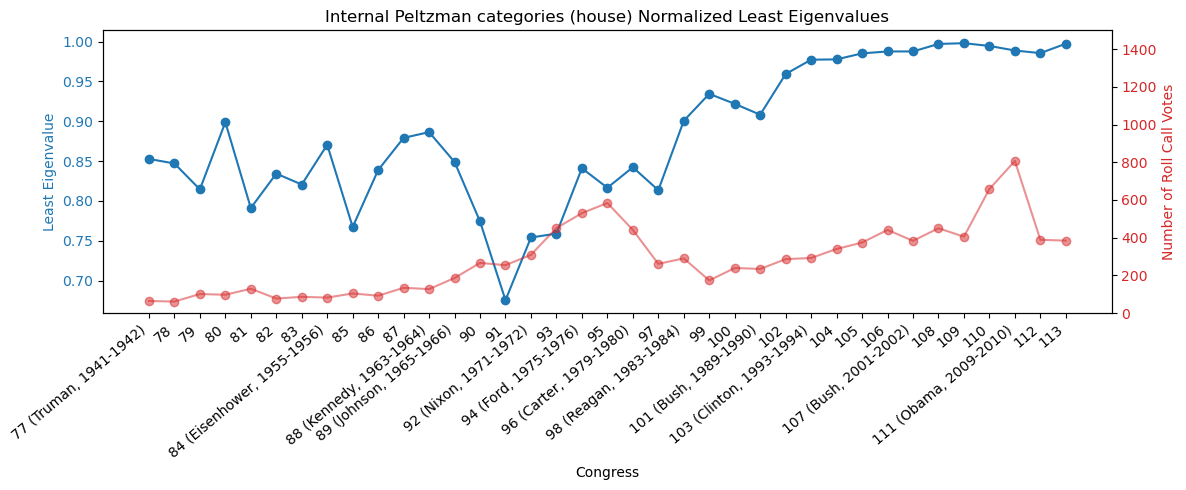

In [72]:
fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list, eigenvalue_list, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks and labels based on congress_years_dic
ax1.set_xticks(congress_list)

# Initialize previous president
prev_president = None

# Loop through congress_list and update x-axis labels
x_labels = []
for congress in congress_list:
    current_president = congress_years_dic[congress][0]

    if prev_president is None or current_president != prev_president:
        x_labels.append(f"{congress} ({congress_years_dic[congress][0]}, {congress_years_dic[congress][1]})")
    else:
        x_labels.append(str(congress))

    prev_president = current_president

ax1.set_xticklabels(x_labels, rotation=40, ha="right")

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list = [n_votes_dict[x] for x in congress_list]
color = 'tab:red'
ax2.set_ylabel('Number of Roll Call Votes', color=color)
ax2.plot(congress_list, n_votes_list, 'o-', color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1500])

output = '../plots/norm_least_eigenvalues/'+chamber+'_peltzman/internal_nle.png'

# set title
plt.title('Internal Peltzman categories ('+chamber+') Normalized Least Eigenvalues')

fig.tight_layout()
plt.savefig(output)

In [73]:
eigenvalues = {}
n_votes_dict = {}  # Dictionary to store the number of votes for each congress

for csv in tqdm(glob.glob(edgelists_path + 'votes_'+chamber+'_peltzman_edges/' + 'foreign' + '/*.csv')):
	n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))


	# Rest of your existing code to compute eigenvalues
	temp = pd.read_csv(thresholds_path +chamber+'_peltzman_thresholds/' + 'foreign' + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
	threshold_pos = temp.iloc[0]['pos_threshold']
	threshold_neg = temp.iloc[0]['neg_threshold']
	n_votes = temp.iloc[0]['n_votes']  # Read the 'n_votes' column
	n_votes_dict[n_congress] = n_votes  # Store the number of votes

	# Read the CSV file into a pandas DataFrame
	df = pd.read_csv(csv)
	df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
	df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
	df = pd.concat([df_pos, df_neg])

	# Create a graph from the DataFrame
	G = nx.from_pandas_edgelist(df, 'source', 'target')

	# check if df is empty
	if df.empty:
		continue
	else:
		# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

	least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
	eigenvalues[n_congress] = least_eigevalue
	
	
#Plot the eigenvalues on the left y-axis
congress_list = sorted(eigenvalues.keys())
eigenvalue_list = [eigenvalues[x] for x in congress_list]


100%|██████████| 37/37 [00:46<00:00,  1.25s/it]


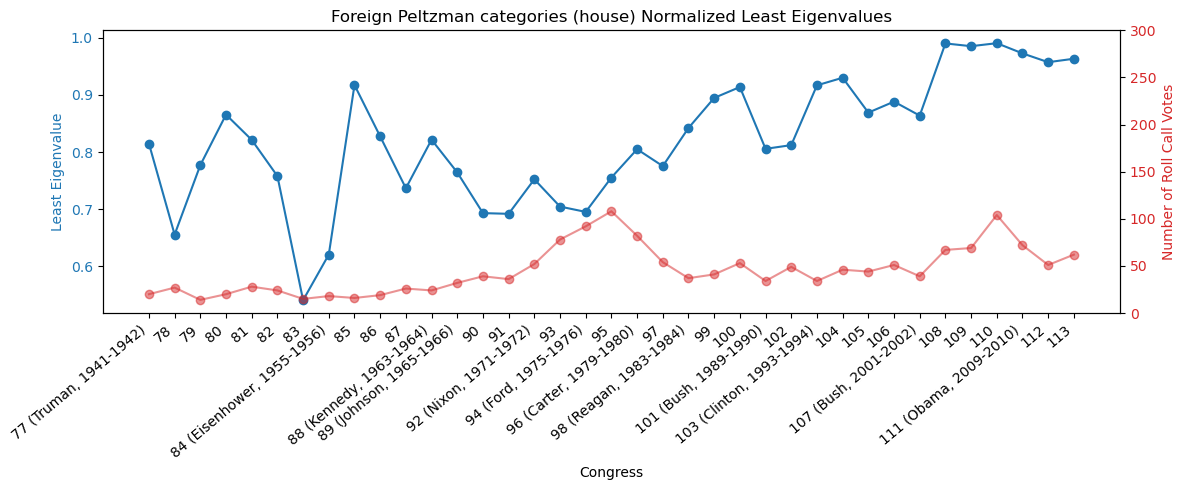

In [75]:
fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list, eigenvalue_list, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks and labels based on congress_years_dic
ax1.set_xticks(congress_list)

# Initialize previous president
prev_president = None

# Loop through congress_list and update x-axis labels
x_labels = []
for congress in congress_list:
    current_president = congress_years_dic[congress][0]

    if prev_president is None or current_president != prev_president:
        x_labels.append(f"{congress} ({congress_years_dic[congress][0]}, {congress_years_dic[congress][1]})")
    else:
        x_labels.append(str(congress))

    prev_president = current_president

ax1.set_xticklabels(x_labels, rotation=40, ha="right")

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list = [n_votes_dict[x] for x in congress_list]
color = 'tab:red'
ax2.set_ylabel('Number of Roll Call Votes', color=color)
ax2.plot(congress_list, n_votes_list, 'o-', color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 300])

output = '../plots/norm_least_eigenvalues/'+chamber+'_peltzman/foreign_nle.png'

# set title
plt.title('Foreign Peltzman categories ('+chamber+') Normalized Least Eigenvalues')

fig.tight_layout()
plt.savefig(output)

## PLOTS (SENATE)

In [54]:
chamber = 'senate'

In [61]:
eigenvalues = {}
n_votes_dict = {}  # Dictionary to store the number of votes for each congress

for csv in tqdm(glob.glob(edgelists_path + 'votes_'+chamber+'_peltzman_edges/' + 'internal' + '/*.csv')):
	n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))


	# Rest of your existing code to compute eigenvalues
	temp = pd.read_csv(thresholds_path +chamber+'_peltzman_thresholds/' + 'internal' + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
	threshold_pos = temp.iloc[0]['pos_threshold']
	threshold_neg = temp.iloc[0]['neg_threshold']
	n_votes = temp.iloc[0]['n_votes']  # Read the 'n_votes' column
	n_votes_dict[n_congress] = n_votes  # Store the number of votes

	# Read the CSV file into a pandas DataFrame
	df = pd.read_csv(csv)
	df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
	df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
	df = pd.concat([df_pos, df_neg])

	# Create a graph from the DataFrame
	G = nx.from_pandas_edgelist(df, 'source', 'target')

	# check if df is empty
	if df.empty:
		continue
	else:
		# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

	least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
	eigenvalues[n_congress] = least_eigevalue
	
	
#Plot the eigenvalues on the left y-axis
congress_list = sorted(eigenvalues.keys())
eigenvalue_list = [eigenvalues[x] for x in congress_list]

100%|██████████| 37/37 [00:02<00:00, 13.56it/s]


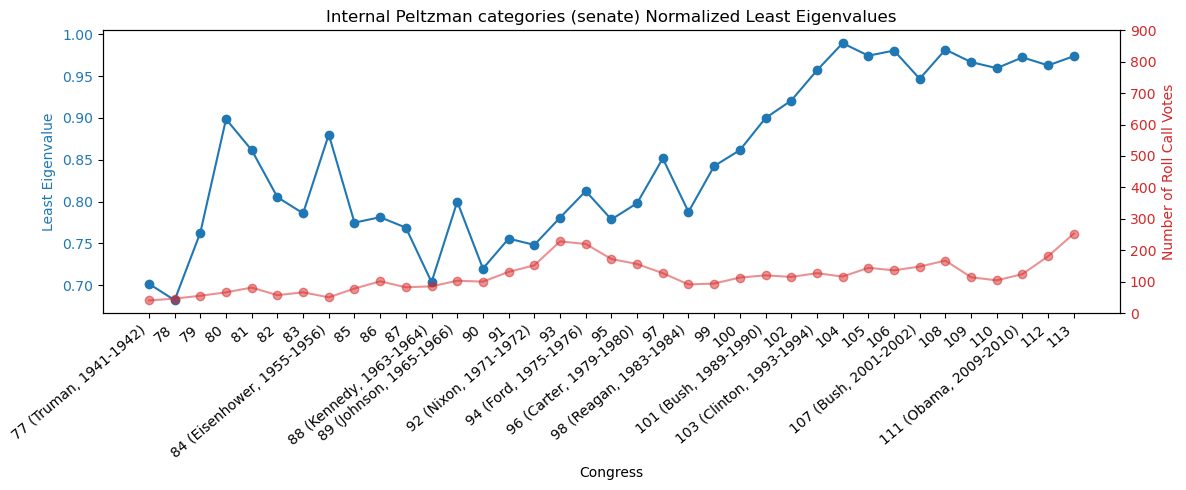

In [66]:
fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list, eigenvalue_list, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks and labels based on congress_years_dic
ax1.set_xticks(congress_list)

# Initialize previous president
prev_president = None

# Loop through congress_list and update x-axis labels
x_labels = []
for congress in congress_list:
    current_president = congress_years_dic[congress][0]

    if prev_president is None or current_president != prev_president:
        x_labels.append(f"{congress} ({congress_years_dic[congress][0]}, {congress_years_dic[congress][1]})")
    else:
        x_labels.append(str(congress))

    prev_president = current_president

ax1.set_xticklabels(x_labels, rotation=40, ha="right")

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list = [n_votes_dict[x] for x in congress_list]
color = 'tab:red'
ax2.set_ylabel('Number of Roll Call Votes', color=color)
ax2.plot(congress_list, n_votes_list, 'o-', color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 900])

output = '../plots/norm_least_eigenvalues/'+chamber+'_peltzman/internal_nle.png'

# set title
plt.title('Internal Peltzman categories ('+chamber+') Normalized Least Eigenvalues')

fig.tight_layout()
plt.savefig(output)

In [67]:
eigenvalues = {}
n_votes_dict = {}  # Dictionary to store the number of votes for each congress

for csv in tqdm(glob.glob(edgelists_path + 'votes_'+chamber+'_peltzman_edges/' + 'foreign' + '/*.csv')):
	n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))


	# Rest of your existing code to compute eigenvalues
	temp = pd.read_csv(thresholds_path +chamber+'_peltzman_thresholds/' + 'foreign' + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
	threshold_pos = temp.iloc[0]['pos_threshold']
	threshold_neg = temp.iloc[0]['neg_threshold']
	n_votes = temp.iloc[0]['n_votes']  # Read the 'n_votes' column
	n_votes_dict[n_congress] = n_votes  # Store the number of votes

	# Read the CSV file into a pandas DataFrame
	df = pd.read_csv(csv)
	df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
	df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
	df = pd.concat([df_pos, df_neg])

	# Create a graph from the DataFrame
	G = nx.from_pandas_edgelist(df, 'source', 'target')

	# check if df is empty
	if df.empty:
		continue
	else:
		# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

	least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
	eigenvalues[n_congress] = least_eigevalue
	
	
#Plot the eigenvalues on the left y-axis
congress_list = sorted(eigenvalues.keys())
eigenvalue_list = [eigenvalues[x] for x in congress_list]

100%|██████████| 37/37 [00:02<00:00, 14.21it/s]


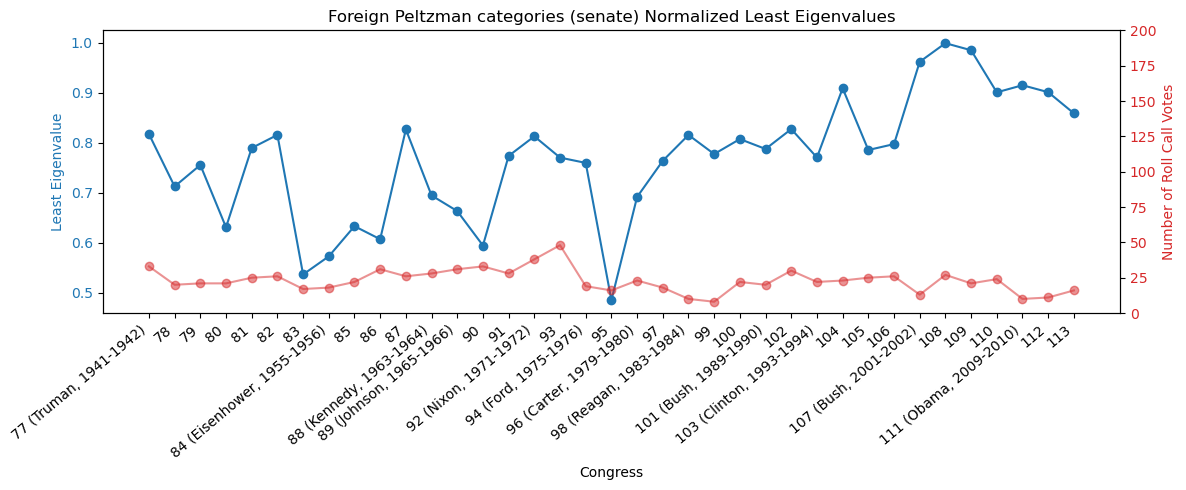

In [68]:
fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list, eigenvalue_list, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks and labels based on congress_years_dic
ax1.set_xticks(congress_list)

# Initialize previous president
prev_president = None

# Loop through congress_list and update x-axis labels
x_labels = []
for congress in congress_list:
    current_president = congress_years_dic[congress][0]

    if prev_president is None or current_president != prev_president:
        x_labels.append(f"{congress} ({congress_years_dic[congress][0]}, {congress_years_dic[congress][1]})")
    else:
        x_labels.append(str(congress))

    prev_president = current_president

ax1.set_xticklabels(x_labels, rotation=40, ha="right")

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list = [n_votes_dict[x] for x in congress_list]
color = 'tab:red'
ax2.set_ylabel('Number of Roll Call Votes', color=color)
ax2.plot(congress_list, n_votes_list, 'o-', color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 200])

output = '../plots/norm_least_eigenvalues/'+chamber+'_peltzman/foreign_nle.png'

# set title
plt.title('Foreign Peltzman categories ('+chamber+') Normalized Least Eigenvalues')

fig.tight_layout()
plt.savefig(output)

______________________________________________